# Time Series
This example idea comes from some of my previous research in macroeconomics. The dataset is taken from Penn World Tables most recent release of data. The data for countries with the highest quality was taken, leaving a dataset on 60 countries. There are observations of each countries GDP, consumption, and investment aggregates. After transforming the data to growth rates and standardizing I perform this analysis. 

I tried a few things for this ML exercise. 
- Do a PCA analysis to extract a world factor. The world factor should represent to some degree the level of globalization and the extent to which the economies of the world co-move together. 
- Use PCA analysis to see if there are significant regional factors. 
- Use Elastic Net to shrink parameters that are not useful for prediction to 0
- Do a large VAR(1) and use Elastic Net to shrink parameters to 0 that are not useful for prediction, and compare this to the standard VAR(1) approach. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error


In [3]:
world_data = pd.read_csv('kow_standardized.csv', index_col=False, 
                         header=None)
world_data = world_data.transpose()

In [4]:
def extractFactor(data):
    cov = np.cov(data)
    e, ev = np.linalg.eigh(cov)
    idx = np.argsort(e)
    ev = ev[:,idx]
    components = ev@data
    return components.iloc[:,0]

wf = extractFactor(world_data)


# Defining the regions
These indices are the different regions in the sample. The regions are treated as given and the estimation will reveal how valid grouping them this way is. Many other subsequent papers have grouped these regions differently since Kose, Otrok and Whiteman's 2003 paper, e.g., Kose, Otrok, Whiteman 2012. 

In [5]:
north_america = [0,8]
oceania = [9,14]
latin_america = [15,68]
europe = [69,122]
africa = [123, 143]
asia_minor = [144,161]
asia_dev = [162, 179]

# Extracting regional factors
In what follows the PCA method from python is used to extract the 
seven regional factors. Regions are defined based on the research of Kose, Otrok, Whiteman 2003. The consist of North America, Oceania, Latin America, Europe, Africa, Asia Developing, Asia Developed. 

In [6]:
na_region = world_data.iloc[:, north_america[0]:north_america[1]]
naf = extractFactor(na_region)

ocean_region = world_data.iloc[:, oceania[0]:oceania[1]]
oceanf = extractFactor(ocean_region)

la_region = world_data.iloc[:, latin_america[0]:latin_america[1]]
laf = extractFactor(la_region)

eur_region = world_data.iloc[:, europe[0]:europe[1]]
eurf = extractFactor(eur_region)

afr_region = world_data.iloc[:, africa[0]:africa[1]]
afrf = extractFactor(afr_region)

asm_region = world_data.iloc[:, asia_minor[0]:asia_minor[1]]
asmf = extractFactor(asm_region)

asd_region = world_data.iloc[:, asia_dev[0]:asia_dev[1]]
asdf = extractFactor(asd_region)

# Setup of baseline model and Elastic Net
The poitn of this exercise is to see how useful the global factor is for prediction, and to verify or reject the conclusions of a very widely cited paper in the American Economic Review journal by Kose, Otrok and Whiteman 2003. In this paper they claimed that there was a very significant global factor, indicative of a global business cycle. 

There are significant differences between their methodology and mine own here. They modeled the system as an autoregressive process centered at 0, 
$$ y_{it} = \beta_w f_{wt} + \beta_r f_{rt} + \beta_c f_{ct} + \varepsilon_{it} ,$$
$$ f_{jt} = f_{jt-1} +\nu_{jt}, $$
where, 
$$ \varepsilon_{it} = \phi_1 \varepsilon_{it-1} + \phi_2 \varepsilon_{it-2} + \phi_3 \varepsilon_{it-3} + u_{it}, $$
and $ \nu $ is modeled similarly, as an AR(3) process. Here $u_{it} $ is the unforecastable component, modeled as a stochastic process arising from a $ \mathcal{N}(0,\sigma^2) $. Note the indices $t$ range from $1,...,58$, $i = 1, ..., 180$ and j represents either the world, regional, or country factors. 

In contrast, I will be estimating a far simpler model. There will be no attempt to estimate dynamics of the factor, instead I will take it as an exogeneous process given by the decomposition of the principal components of the covariance matrix given by the system generated between the 180 series in $y_t$. For each $i\in \{1,...,180\} $ a univerate linear model will be estimated with a world factor and a regional factor, 
$$ y_{it} = \beta_w f_{wt} + \beta_r f_{rt} + \varepsilon_{it} $$ 

The interest lies in which parameters Elastic Net will shrink out to 0, and what kind of performance increase that will give to the model. 

In [8]:
en = ElasticNet(fit_intercept=True, alpha=1, l1_ratio=.5)
base = LinearRegression(fit_intercept=True)
c = 0
feature_select = pd.DataFrame(data={"wf":[], "r":[]})
tsp = TimeSeriesSplit(2)
grid = {'alpha':np.linspace(0.01,1,10), 'l1_ratio':np.linspace(0.01,.99,10)}
search = GridSearchCV(en, grid, scoring='neg_mean_absolute_error', )
score_comparison = pd.DataFrame(data={"ElasticNet":[], "LinearReg":[]})


This code puts together the right regional factors and the world factor. For each equation a univariate regression is run with a corresponding elastic net regression. 

In [9]:
Xna = pd.concat([pd.DataFrame(wf), pd.DataFrame(naf)], axis=1)

for i in range(0,9):
    print(i)
    y = world_data.iloc[:,i]
    baseline_score = cross_val_score(base, Xna, y, scoring='neg_mean_absolute_error')
    score_comparison.loc[i,'LinearReg'] = np.mean(baseline_score)
    res = search.fit(Xna, y)
    score_comparison.loc[i,'ElasticNet']= res.best_score_
    en = ElasticNet(fit_intercept=True, alpha=res.best_params_['alpha'], 
                    l1_ratio=res.best_params_['l1_ratio'])
    en.fit(Xna,y)    
    d={"wf":[en.coef_[0]], "r":[en.coef_[1]]}
    feature_select = pd.concat([feature_select, pd.DataFrame(data=d)], axis=0)

0
1
2
3
4
5
6
7
8


In [10]:
Xoc = pd.concat([pd.DataFrame(wf), pd.DataFrame(oceanf)], axis=1)
for i in range(9,15):
    print(i)
    y = world_data.iloc[:,i]
    baseline_score = cross_val_score(base, Xoc, y, 
                                     scoring='neg_mean_absolute_error')
    score_comparison.loc[i,'LinearReg'] = np.mean(baseline_score)
    res = search.fit(Xoc, y)
    score_comparison.loc[i,'ElasticNet']= res.best_score_
    en = ElasticNet(fit_intercept=True, alpha=res.best_params_['alpha'], 
                    l1_ratio=res.best_params_['l1_ratio'])
    en.fit(Xoc,y)    
    d={"wf":[en.coef_[0]], "r":[en.coef_[1]]}
    feature_select = pd.concat([feature_select, pd.DataFrame(data=d)], 
                               axis=0)


9
10
11
12
13
14


In [11]:
Xla = pd.concat([pd.DataFrame(wf), pd.DataFrame(laf)], axis=1)  
for i in range(15,69):
    print(i)
    y = world_data.iloc[:,i]
    baseline_score = cross_val_score(base, Xla, y, 
                                     scoring='neg_mean_absolute_error')
    score_comparison.loc[i, 'LinearReg'] = np.mean(baseline_score)
    res = search.fit(Xla, y)
    score_comparison.loc[i, 'ElasticNet']= res.best_score_
    en = ElasticNet(fit_intercept=True, alpha=res.best_params_['alpha'], 
                    l1_ratio=res.best_params_['l1_ratio'])
    en.fit(Xla, y)
    d={"wf":[en.coef_[0]], "r":[en.coef_[1]]}
    feature_select = pd.concat([feature_select, pd.DataFrame(data=d)], 
                               axis=0)

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


In [12]:
Xeu = pd.concat([pd.DataFrame(wf), pd.DataFrame(eurf)], axis=1)
for i in range(69,123):
    print(i)
    y = world_data.iloc[:,i]
    baseline_score = cross_val_score(base, Xeu, y, 
                                     scoring='neg_mean_absolute_error')
    score_comparison.loc[i, 'LinearReg'] = np.mean(baseline_score)
    res = search.fit(Xeu, y)
    score_comparison.loc[i, 'ElasticNet']= res.best_score_
    en = ElasticNet(fit_intercept=True, alpha=res.best_params_['alpha'], 
                    l1_ratio=res.best_params_['l1_ratio'])
    en.fit(Xeu, y)
    d={"wf":[en.coef_[0]], "r":[en.coef_[1]]}
    feature_select = pd.concat([feature_select, pd.DataFrame(data=d)],
                               axis=0)

69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


In [13]:
Xaf = pd.concat([pd.DataFrame(wf), pd.DataFrame(afrf)], axis=1)
for i in range(123,144):
    print(i)
    y = world_data.iloc[:,i]
    baseline_score = cross_val_score(base, Xaf, y, 
                                     scoring='neg_mean_absolute_error')
    score_comparison.loc[i, 'LinearReg'] = np.mean(baseline_score)
    res = search.fit(Xaf, y)
    score_comparison.loc[i, 'ElasticNet']= res.best_score_
    en = ElasticNet(fit_intercept=True, alpha=res.best_params_['alpha'], 
                    l1_ratio=res.best_params_['l1_ratio'])
    en.fit(Xaf, y)
    d={"wf":[en.coef_[0]], "r":[en.coef_[1]]}
    feature_select = pd.concat([feature_select, pd.DataFrame(data=d)], 
                               axis=0)

123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


In [14]:
Xam = pd.concat([pd.DataFrame(wf), pd.DataFrame(asmf)], axis=1)
for i in range(144,162):
    print(i)
    y = world_data.iloc[:,i]
    baseline_score = cross_val_score(base, Xam, y, 
                                     scoring='neg_mean_absolute_error')
    score_comparison.loc[i, 'LinearReg'] = np.mean(baseline_score)
    res = search.fit(Xam, y)
    score_comparison.loc[i, 'ElasticNet']= res.best_score_
    en = ElasticNet(fit_intercept=True, alpha=res.best_params_['alpha'], 
                    l1_ratio=res.best_params_['l1_ratio'])
    en.fit(Xam, y)
    d={"wf":[en.coef_[0]], "r":[en.coef_[1]]}
    feature_select = pd.concat([feature_select, pd.DataFrame(data=d)],
                               axis=0)

144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


In [15]:
Xad = pd.concat([pd.DataFrame(wf), pd.DataFrame(asdf)], axis=1)
for i in range(162,180):
    print(i)
    y = world_data.iloc[:,i]
    baseline_score = cross_val_score(base, Xad, y, 
                                     scoring='neg_mean_absolute_error')
    score_comparison.loc[i, 'LinearReg'] = np.mean(baseline_score)
    res = search.fit(Xad, y)
    score_comparison.loc[i, 'ElasticNet']= res.best_score_
    en = ElasticNet(fit_intercept=True, alpha=res.best_params_['alpha'], 
                    l1_ratio=res.best_params_['l1_ratio'])
    en.fit(Xad, y)
    d={"wf":[en.coef_[0]], "r":[en.coef_[1]]}
    feature_select = pd.concat([feature_select, pd.DataFrame(data=d)],
                               axis=0)


feature_select_bool = abs(feature_select) < .01


162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [16]:
feature_select_bool.reset_index(drop=True,inplace=True)


# Results of EN
The results are put together in the pandas Data Frame below. The elastic net shrinks some parameters to zero. In order to make this clearer an arbitrary cutoff was chosen as 0.01 (e.g. but other smaller tolerance levels could be used). Values higher than this are considered to be in the regression. 

A summary of the key findings are summarized below: 
- The North American region has a significant factor, none of its parameters were regularized to 0 
- The European region was well chosen. The following countries had only one of the series of the three possible shrunk to 0: Finland (GDP), Luxembourg (investment), Norway (consumption), Espana (consumption), Sweden (consumption), Switzerland (GDP), Great Britain (consumtion), 
- Only one of the countries in Europe could be considered as not fitting into the region that well, which is unsurprisingly Greece. Greece had two series shrunk to 0 (GDP, Cons). However, given that Greece has struggled economically, struggles that have especially come to light since 2010, it is no surprise that Greece does not show much comovement with series in this region. 
- The world factor explained a large amount of the variance in the various processes. However, for some developing nations it seems that the world factor is not useful for predicting movements in key macro indicators. Costa Rica seems to display no benefit to having the world factor. The Domincan Republic is similar, two of the three series are shrunk to 0. Likewise Guatemala (two of three are 0), Jamaica (two of three 0), Panama (two of three 0), Argentina (two of three 0), Brazil (surprisingly two of three 0), Uruguay (two of three 0), Greece (two of three 0), Senegal (two of three 0)
- Apparently, since the nations which are not well explained by the world factor are developing their economies are more detached from global processes unlike their developed neighbors. The region which seems most detached is Latin America. Surprsingly Brazil was detached from the world factor. Being one of the major emerging markets I would have expected it to be tied into movements with the rest of the world. However, despite this status it did not appear to have a strong connection to the rest of the world factor. 

In [17]:
pd.set_option('display.max_rows', None)
pd.options.display.max_columns = None
country_index = pd.read_csv('/home/dillon/GoogleDrive/Datasets/kowindex.csv',
           header=None)
pd.concat([country_index.iloc[:,1], feature_select_bool], axis=1).transpose()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
1,gdpUSA,conUSA,investUSA,gdpCAN,conCAN,investCAN,gdpMEX,conMEX,investMEX,gdpAUS,conAUS,investAUS,gdpNZL,conNZL,investNZL,gdpCRI,conCRI,investCRI,gdpDOM,conDOM,investDOM,gdpSLV,conSLV,investSLV,gdpGTM,conGTM,investGTM,gdpHND,conHND,investHND,gdpJAM,conJAM,investJAM,gdpPAN,conPAN,investPAN,gdpTTO,conTTO,investTTO,gdpARG,conARG,investARG,gdpBOL,conBOL,investBOL,gdpBRA,conBRA,investBRA,gdpCHL,conCHL,investCHL,gdpCOL,conCOL,investCOL,gdpECU,conECU,investECU,gdpPRY,conPRY,investPRY,gdpPER,conPER,investPER,gdpURY,conURY,investURY,gdpVEN,conVEN,investVEN,gdpFRA,conFRA,investFRA,gdpAUT,conAUT,investAUT,gdpBEL,conBEL,investBEL,gdpDNK,conDNK,investDNK,gdpFIN,conFIN,investFIN,gdpDEU,conDEU,investDEU,gdpGRC,conGRC,investGRC,gdpISL,conISL,investISL,gdpIRL,conIRL,investIRL,gdpITA,conITA,investITA,gdpLUX,conLUX,investLUX,gdpNLD,conNLD,investNLD,gdpNOR,conNOR,investNOR,gdpPRT,conPRT,investPRT,gdpESP,conESP,investESP,gdpSWE,conSWE,investSWE,gdpCHE,conCHE,investCHE,gdpGBR,conGBR,investGBR,gdpCMR,conCMR,investCMR,gdpCIV,conCIV,investCIV,gdpKEN,conKEN,investKEN,gdpMAR,conMAR,investMAR,gdpSEN,conSEN,investSEN,gdpZAF,conZAF,investZAF,gdpZWE,conZWE,investZWE,gdpBGD,conBGD,investBGD,gdpIND,conIND,investIND,gdpIDN,conIDN,investIDN,gdpPAK,conPAK,investPAK,gdpPHL,conPHL,investPHL,gdpLKA,conLKA,investLKA,gdpHKG,conHKG,investHKG,gdpJPN,conJPN,investJPN,gdpKOR,conKOR,investKOR,gdpMYS,conMYS,investMYS,gdpSGP,conSGP,investSGP,gdpTHA,conTHA,investTHA
wf,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,True,False,False,True,True,True,False,False,True,True,True,False,False,True,False,True,False,True,False,True,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,False,True,False,True,True,False,True,False,False,True,True,True,False,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,False,True,False,False,True,False,True,True,True,False,True,False,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,False,False,True,True,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True,True,False,True,False,True,True,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True
r,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,True,True,False,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,False,True,True,False,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,False,False,True,True,False,True,False,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,False,False,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True


# Review and thoughts about the Giskard testing framework for this example
The model I have implemented is something that would have interested me as a researcher. There is currently some research done by Ouyang on Bayesian methods to select the regions, but most researchers take the groups as given. The ML approach could be significant in the field, and it seems like it somewhat bolstered the case of Kose, Otrok, and Whiteman 2003, although the elastic net model is better for forecasting. 

- What would have been helpful from Giskards perspective during this process were simple ways of looking at forecasting performance. This could easily be implemented automatically. 

- In addition a comparison with a baseline model would be helpful. Giskard could implement up to $n$ models and compare them one to another in a matrix with some sort of loss function. 

- Another helpful feature would be impulse response functions (perturbation of inputs). In the next examples I will also explore some more helpful methods that can be implemented. 

# A simple example: VAR(1)
VAR(1) are a popular forecasting tool for macroeconomic data. However, they quickly become oversaturated with parameters when the number of equations approachs $T$, time. In this case there are 58 observations in $T$ while there are 180 equations. Clearly, this falls into the case where oversaturation could quickly become a problem. The matrix $ (X^TX)^{-1} $ would likely have a numerical issues due to multicolinearly. 

Elastic net can be used to create a more parsimonious model of this system. Since the world economies exhibit comovement as the results above suggest, a VAR(1) could be a useful model to capture this comovement. The elastic net regularization properties will shrink features that are not needed in the system to 0. 

For comparison this model is compared to a ols regression using all the features. 

In [18]:
pd.set_option('display.max_rows', 10)

In [19]:
Varx = world_data.iloc[0:(world_data.shape[0]-1),:]
var_score_comparison = pd.DataFrame(data={"ElasticNet":[], "LinearReg":[]})
for i in range(0,180):
    print(i)
    y = world_data.iloc[1:,i]
    en = ElasticNetCV(l1_ratio=grid['l1_ratio'], eps=.001, n_alphas=10,
                      fit_intercept=True,max_iter=3000, cv=tsp)
    en.fit(Varx, world_data.iloc[1:,i])
    yfit = en.predict(Varx)
    var_score_comparison.loc[i, 'ElasticNet'] = -mean_absolute_error(y, yfit)
    baseline_scores = cross_val_score(base, Varx, world_data.iloc[1:,i])
    var_score_comparison.loc[i, 'LinearReg'] = np.mean(baseline_scores)

0
1
2
3
4
5


/home/dillon/miniconda3/envs/test/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.197e-03, tolerance: 5.578e-03
  model = cd_fast.enet_coordinate_descent(


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


/home/dillon/miniconda3/envs/test/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.474e-03, tolerance: 5.509e-03
  model = cd_fast.enet_coordinate_descent(


139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


The results show that the VAR(1) with shrinkage outperform the simple VAR(1) model with no shrinkage. For some of the equations the results are vastly superior. This shows that overfitting is clearly a problem with such a large system and that shrinkage helps for forecasting these macroeconomic series. In no equation was the standard VAR(1) model better than the EN model. 

## Ideas for adaptation into Giskard's framework

Time series is different from other types of data in that the sequential order always matters. Prediction of the future are based on the past actions of the data. In fact, if the data displays no properties to revert to its mean, i.e., is not stationary then prediction is impossible or at the least much more difficult to do. 

Also, the idea of systems of equations are not typically the types of problems machine or deep learning is focused. Deep learning tries to reduce every problem to univariate processes, but macroeconomic data is often endogeneous. It is questionable how well the assumptions of deep learning perform given the systematic nature of macroeconomic data perform, especially given its dismal performance in comparison to the most simple time series models like ARIMA. I assume that this categorization holds across other disiplines as well and not just in economics. 

Nevertheless, to deploy a good testing framework for time series the most salient issues facing the time series modeler are the following:
- Is the data stationary? 
- What is the in sample/out of sample performance? 
- What would happen if the inputs changed?

I will address each in the next sections.

# Stationarity
Stationarity is, of course, incredibly important for trying to predict time series data. If the data never reverts to its mean, but is instead a random walk, then what is the sense in trying to predict this series? 

# Giskard features to deal with stationarity
Users of Giskard may be aware of this problem and simply wish to submit the *data* to Giskard with the identified outcome variable and features. Giskard can then perform unit root tests on the stochastic processes, such as the Augmented Dickey-Fuller test for unit roots, which is considered the go-to test for integrated series. Giskard could then suggest the following options: 
- Suggest transformations of the data, log differencing, differencing I times, de-trending, or de-seasoning the data

Given my example with the Penn World Tables dataset on country level GDP, consumption and investment the unit root  tests can be performed simply with python: 

In [20]:
from statsmodels.tsa.stattools import adfuller
for i in range(world_data.shape[1]):
    pval = float(adfuller(world_data.iloc[:,i])[1])
    print("{:.4f}".format(pval))
    

0.0000
0.0025
0.4513
0.0000
0.0330
0.5067
0.0000
0.0000
0.5094
0.0000
0.0022
0.3927
0.0008
0.0000
0.0134
0.0002
0.0000
0.0259
0.0000
0.0000
0.0615
0.0168
0.0018
0.0818
0.0035
0.0393
0.0854
0.0000
0.0000
0.1350
0.0000
0.0000
0.1290
0.0000
0.0000
0.1542
0.1424
0.0568
0.1084
0.0000
0.0000
0.1368
0.0116
0.0000
0.1878
0.0006
0.4268
0.7168
0.0000
0.0001
0.1830
0.0000
0.0000
0.1902
0.0000
0.0000
0.5060
0.0000
0.0060
0.4419
0.0001
0.0000
0.0159
0.0001
0.0109
0.0031
0.9977
0.9882
0.7710
0.0026
0.1970
0.5957
0.0000
0.6119
0.8259
0.0000
0.3498
0.4726
0.0000
0.0283
0.6375
0.0001
0.0124
0.4344
0.0000
0.0073
0.0320
0.0059
0.0382
0.8224
0.0001
0.0000
0.0898
0.0000
0.0063
0.0531
0.5159
0.0314
0.8418
0.0000
0.0001
0.0010
0.0007
0.0604
0.5559
0.0026
0.0000
0.1802
0.6021
0.3019
0.8479
0.0059
0.0239
0.4754
0.0000
0.0003
0.4563
0.0021
0.0584
0.1297
0.0000
0.0002
0.4399
0.0238
0.0240
0.2614
0.0000
0.0000
0.2775
0.0000
0.0000
0.1877
0.0000
0.0008
0.0818
0.0000
0.0000
0.8846
0.0005
0.0008
0.4551
0.0000
0.0000

The data have already been log first differenced. Most of the series are showing no evidence of unit root ($H_0 : $ unit root). The series that are showing evidence of unit root I will not transform any more for analysis since overdifferencing is problematic. 

Solutions for unit root include: 
- Log first differencing
- Differencing
- Deseasoning the data with exponential smoothing (Holts method)
- Detrending the data with a time trend


# Example time series plots
Time series plots can be inspected for evidence of unit roots or trends:

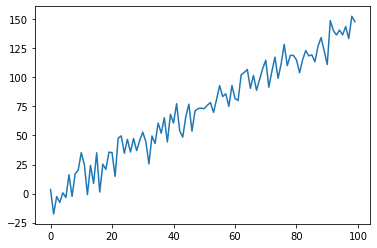

In [21]:
T = np.arange(0,100,1)
y = 1.5 * T + np.random.normal(0,10,(100))
plt.plot(y)

Clearly, the data shows a trend which is obvious graphically. There are tests for linear time trends and seasonalitiy, see e.g. Hamilton (1994). A diagnositc result with these tests would be helpful to know which transformation to implement, which Giskard could provide. In summary, the most helpful diagnostics Giskard could give for a modeler who was non-technical but wanted visual inspection would be:
- Time series plots of all series
- Unit root tests on all series
- Tests for seasonality and trends
- Proposed solutions for these problems (already covered above)
- Levels of autocorrelation and partial autocorrelation observed in the series

# Time Series models forecasting performance 
Once a model is submitted to Giskard then one can evaluate its performance similarly to how Giskard already evaluates other models. The methods of validation would need to take into account the sequential nature of time series data and make sure the cross-validation methods being used were not randomizing the sample. The most valuable diagnostics would be its forecasting performance, perhaps under different measures of loss, like mean absolute, mean squared, or median absolute loss. 

This was done previously above: 

In [22]:
pd.options.display.max_rows = None
var_score_comparison

,ElasticNet,LinearReg
0,-0.647497,-0.698032
1,-0.110000,-0.885935
2,-0.067737,-1.359108
3,-0.449501,-1.117737
4,-0.256992,-2.088626
5,-0.008787,-0.105144
6,-0.592821,-2.097847
7,-0.620764,-2.781272
8,-0.372773,-1.895084
9,-0.718570,-1.929865


# Time series models perturbation
Perturbation in time series models is done using Impulse Response Functions. The impulse responses give the partial derivatives of a change in the system to one equation while holding the others constant and seeing how the dynamics of the entire system respond to say, a one standard deviation shock. 

It would be most helpful if Giskard implemented all the impulse response functions to time series models that were in a vector autoregressive form. What would be additionally helpful is if the input to the partial derivatives could be manipulated by the user to see the effects of these changes on the system. 

A simple implementation of this would be simple. In the vase of VAR(1) system above I will take only a subset of the equations for demonstration purposes. Say that we are interested in modeling the US economy with GDP, investment, and consumption growth rates. This is a simple system that can be modeled as a VAR(1) process. 

It is necessary to impose some sort of restrictions upon the system in order to calculate the shocks. It is in modeling that the structural model has uncorrelated errors. However, the reduced form model has some form of heteroskedasticity. Knowledge of the covariance matrix identifying the heteroskdasticity is necessary to perform any analysis of IRFs. 

The most common thing done to identify this is the covariance matrix of the structural residiuals. Then a lower cholesky is taken of this matrix and used to calculate the IRFs. Notice that the lower cholelsky necessarily imposes a sense of causality, the first equation being the one that reacts fastest to changes in the system. 

There are other types of identifying restrictions that can be made to deal with this issue, however, they are more difficult to code and also depend on the researchers preferences and knowledge of the system. 

For most cases taking the lower cholesky is a good starting point. 

In [23]:
usa = world_data.iloc[:,0:3]
usa.columns = ("gdp", "invest", "cons")
usay = usa.iloc[1:,:]

K =usay.transpose().shape[0]
T = usay.transpose().shape[1]

In [70]:
pd.options.display.max_rows = None
usax = usa.iloc[0:T,:]
usax = pd.DataFrame(np.kron(usax, np.ones((K,1))))
one = pd.concat([usax]*K, axis=1)
I = np.identity(K)
two = np.kron(np.tile(I,(T,1)), np.ones((1,3)))
usax = np.multiply(one,two)
xx = usax.transpose()@usax

I = np.identity(xx.shape[0])
xxinv = np.linalg.solve(xx, I)

vecy = usay.to_numpy()
vecy = vecy.flatten()
xy = usax.transpose()@vecy
beta = xxinv@xy

yhat = usax@beta
uhat = vecy - yhat
uhat = pd.DataFrame(uhat.values.reshape((K,T), order='F'))
V = (1/(T-K-1))*uhat@uhat.transpose()
B0lower = np.linalg.cholesky(V)

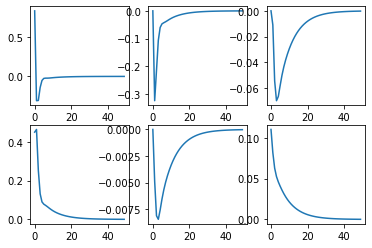

In [111]:
def impulseResponse(A ,B0lower, periods):
    irf = np.zeros((A.shape[0], A.shape[0], periods))
    for i in range(0,periods):
        Thetai = np.linalg.matrix_power(A,i)
        response = Thetai*B0lower
        irf[:,:,i] = response
    return irf
    

A = beta.reshape((K,K), order = 'C')
irf = impulseResponse(A, B0lower, 50)
plt.subplots_adjust()
plt.subplot(231)
plt.plot(irf[0,0,:])
plt.subplot(232)
plt.plot(irf[1,0,:])
plt.subplot(233)
plt.plot(irf[2,0,:])
plt.subplot(234)
plt.plot(irf[1,1,:])
plt.subplot(235)
plt.plot(irf[2,1,:])
plt.subplot(236)
plt.plot(irf[2,2,:])

The cell above shows the perturbation of the inputs to a one standard deviation shock. This can easily be manipulated to larger or smaller shocks by changing the input to the structural VAR(1) error term that was identifed through the reduced form estimation process, $B_0^{-1}$. 

These perturbation graphs are extremely important in time series analysis as they show the effects of changing the inputs. The outcome of the changes is shown graphically above, they are the partial derivatives at each point in time with respect to the unforecastable component, 

$$ \frac{\partial y_t} {\partial w_t'} = \Theta_i $$
$$ \Theta_i = \Phi_i B_0^{-1} $$
$$ \Phi_i = J A^i J^T $$
$$ J = \begin{bmatrix} I_K & 0 & \dots & 0 \end{bmatrix} $$
$$ A = \begin{bmatrix}
 A_1 & A_2 & \dots & A_{p-1} & A_p \\
 I_K & 0 & \dots & 0 & 0 \\
 \vdots & \vdots & \ddots &\vdots & \vdots \\
 0 & 0 & \dots & I_K & 0  
 \end{bmatrix} $$

$p$ is the number of inlcuded lags. 

These graphs could be easily produced for vector autoregressions, and possible other models also, just as I have done above. Additionally, other types of restrictions could be imposed and impulse response functions generated for those as well. 

# Conclusions
Here I will review and address each aspect of implementing a tool for Time Series AI inspection.
## Non-technical inspection
- The non-technical inspection tool can show plots of all the series when clicked upon. The plots are helpful for determining trends and unit roots. 
- The individual series can all be checked for unit roots quickly using the ADF test. 
- The forecasting performance can be given, much like Giskard already does. The difference between $y_t - \hat{y}_t $ can be given and also the out of sample performance. 

## Granular inspection 
- The granular inspection can divide the dataset up in different portions in order to compare different examples and do cross validation. This will give a better understanding of how the model will perform out of sample. 

## Perturbation
- Features can be dropped and the models performance can be analyzed after the feature is removed, much like the examples above. 
- Impulse response functions can be easily calculated to evaluate the impact of, say, a standard deviation shock to the system on the other variables. 

## Feedback and Discussion
- This can be collected as it is already, very little changes would be necessary to port over these features to time series. 